# ResNet + ConvNext on ImageNet

### Hardware Check

In [1]:
def get_hardware_info(use_in_notebook=True, install_packages=True):
    import sys
    import subprocess
    import importlib.util

    if install_packages:
        if importlib.util.find_spec("psutil") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "psutil"], check=True)
        if importlib.util.find_spec("gputil") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "gputil"], check=True)
        if importlib.util.find_spec("py-cpuinfo") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "py-cpuinfo"], check=True)

    # import needed packages
    import platform
    import psutil
    import GPUtil
    from cpuinfo import get_cpu_info

    if use_in_notebook:
        if install_packages and importlib.util.find_spec("ipython") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "ipython"], check=True)

        from IPython.display import clear_output
        clear_output()
    else:
        pass
        # os.system('cls' if os.name == 'nt' else 'clear')

    print("-"*32, "\nYour Hardware:\n")

    # General
    print("    ---> General <---")
    print("Operatingsystem:", platform.system())
    print("Version:", platform.version())
    print("Architecture:", platform.architecture())
    print("Processor:", platform.processor())

    # GPU-Information
    print("\n    ---> GPU <---")
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print("GPU Name:", gpu.name)
        print("VRAM Total:", gpu.memoryTotal, "MB")
        print("VRAM Used:", gpu.memoryUsed, "MB")
        print("Utilization:", gpu.load * 100, "%")
    try:
        import torch
        gpus = [torch.cuda.get_device_name(device_nr) for device_nr in range(torch.cuda.device_count())]
        torch_support = False
        if torch.cuda.is_available():
            torch_support = True
            gpu_str = f"({','.join(gpus)})"
        gpu_addition = f" {gpu_str}" if torch_support else ""
        print(f"PyTorch Support: {torch_support}" + gpu_addition)
    except Exception:
        print(f"PyTorch Support: False")

    try:
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        tf_support = False
        if len(gpus) > 0:
            tf_support = True
            gpu_str = f"({','.join(gpus)})"
        gpu_addition = f" {gpu_str}" if tf_support else ""
        print(f"TensorFlow Support: {tf_support}" + gpu_addition)
    except Exception:
        print(f"TensorFlow Support: False")

    # CPU-Information
    print("\n    ---> CPU <---")
    cpu_info = get_cpu_info()
    print("CPU-Name:", cpu_info["brand_raw"])
    print("CPU Kernels:", psutil.cpu_count(logical=False))
    print("Logical CPU-Kernels:", psutil.cpu_count(logical=True))
    print("CPU-Frequence:", psutil.cpu_freq().max, "MHz")
    print("CPU-Utilization:", psutil.cpu_percent(interval=1), "%")


    # RAM-Information
    print("\n    ---> RAM <---")
    ram = psutil.virtual_memory()
    print("RAM Total:", ram.total // (1024**3), "GB")
    print("RAM Available:", ram.available // (1024**3), "GB")
    print("RAM-Utilization:", ram.percent, "%")

    print(f"\n{'-'*32}")



get_hardware_info(use_in_notebook=True, install_packages=True)

-------------------------------- 
Your Hardware:

    ---> General <---
Operatingsystem: Linux
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Architecture: ('64bit', 'ELF')
Processor: x86_64

    ---> GPU <---
PyTorch Support: False
TensorFlow Support: False

    ---> CPU <---
CPU-Name: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU Kernels: 1
Logical CPU-Kernels: 2
CPU-Frequence: 0.0 MHz
CPU-Utilization: 100.0 %

    ---> RAM <---
RAM Total: 12 GB
RAM Available: 10 GB
RAM-Utilization: 13.6 %

--------------------------------


### Imports

In [2]:
import platform
import os
import shutil
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn

import torchvision
from torchvision import transforms

### Helper

In [3]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    title can be None, str or a list of strings.
    """
    import cv2

    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
            img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[3]))
        else:
            # there could be cases where this is wrong
            img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[3], 1))
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}'' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    ax = ax.ravel()
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            cur_img = cur_img
            cmap = "gray"

        cur_ax.imshow(cur_img, cmap=cmap)

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

### Load Data

Loading, preparing and analyzing the ImageNet100 Dataset.

Go to .. and download the "Development kit (Task 1 & 2)" with the file name "ILSVRC2012_devkit_t12.tar.gz" and upload it here in ./data .

Getting a Kaggle API Key (if not already have):
    1. Go to https://www.kaggle.com/ and create or sign in your account
    2. Click on your profile picture > Settings and go to API
    3. Click on 'Create New Token' and the 'kaggle.json' fie should download automatically
    4. Now you can use the following code to load your json file and download the imagenet dataset


In [4]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("clane9/imagenet-100")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.87k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

train-00000-of-00017.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00001-of-00017.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

train-00002-of-00017.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00003-of-00017.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00004-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00005-of-00017.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00006-of-00017.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

train-00007-of-00017.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00008-of-00017.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00009-of-00017.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00010-of-00017.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00011-of-00017.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00012-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00013-of-00017.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00014-of-00017.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00015-of-00017.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00016-of-00017.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/126689 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 126689
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5000
    })
})


In [6]:
dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x160>,
 'label': 0}

In [7]:
dataset["train"][0]["image"].size

(213, 160)

In [8]:
class ImageNet(torch.utils.data.Dataset):
  def __init__(self, data, transforms, *args):
    super().__init__(*args)
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    cur_pil_image, cur_label = self.data[idx]["image"], self.data[idx]["label"]
    cur_pil_image = self.transforms(cur_pil_image)
    return cur_pil_image, cur_label

In [14]:
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    # transforms.RandomResizedCrop(224),
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define train and validation data
train_val_data = dataset["train"]
train_size = int( 0.8*len(train_val_data) )
val_size = int( len(train_val_data) - train_size )
train_data, val_data = torch.utils.data.random_split(train_val_data, [train_size, val_size])

# apply torch dataset wrapper
train_data = ImageNet(train_data, train_transform)
val_data = ImageNet(val_data, test_val_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=4,
    shuffle=True,
    num_workers=4,
)
val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)

# define testdata
test_data = ImageNet(dataset["validation"], test_val_transform)
test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)


show some samples

Got images with shape: torch.Size([9, 224, 224, 3])
Transformed shape to: torch.Size([9, 224, 224, 3])
Using 'seaborn-v0_8'' plotting style.
Making you a beautiful plot...


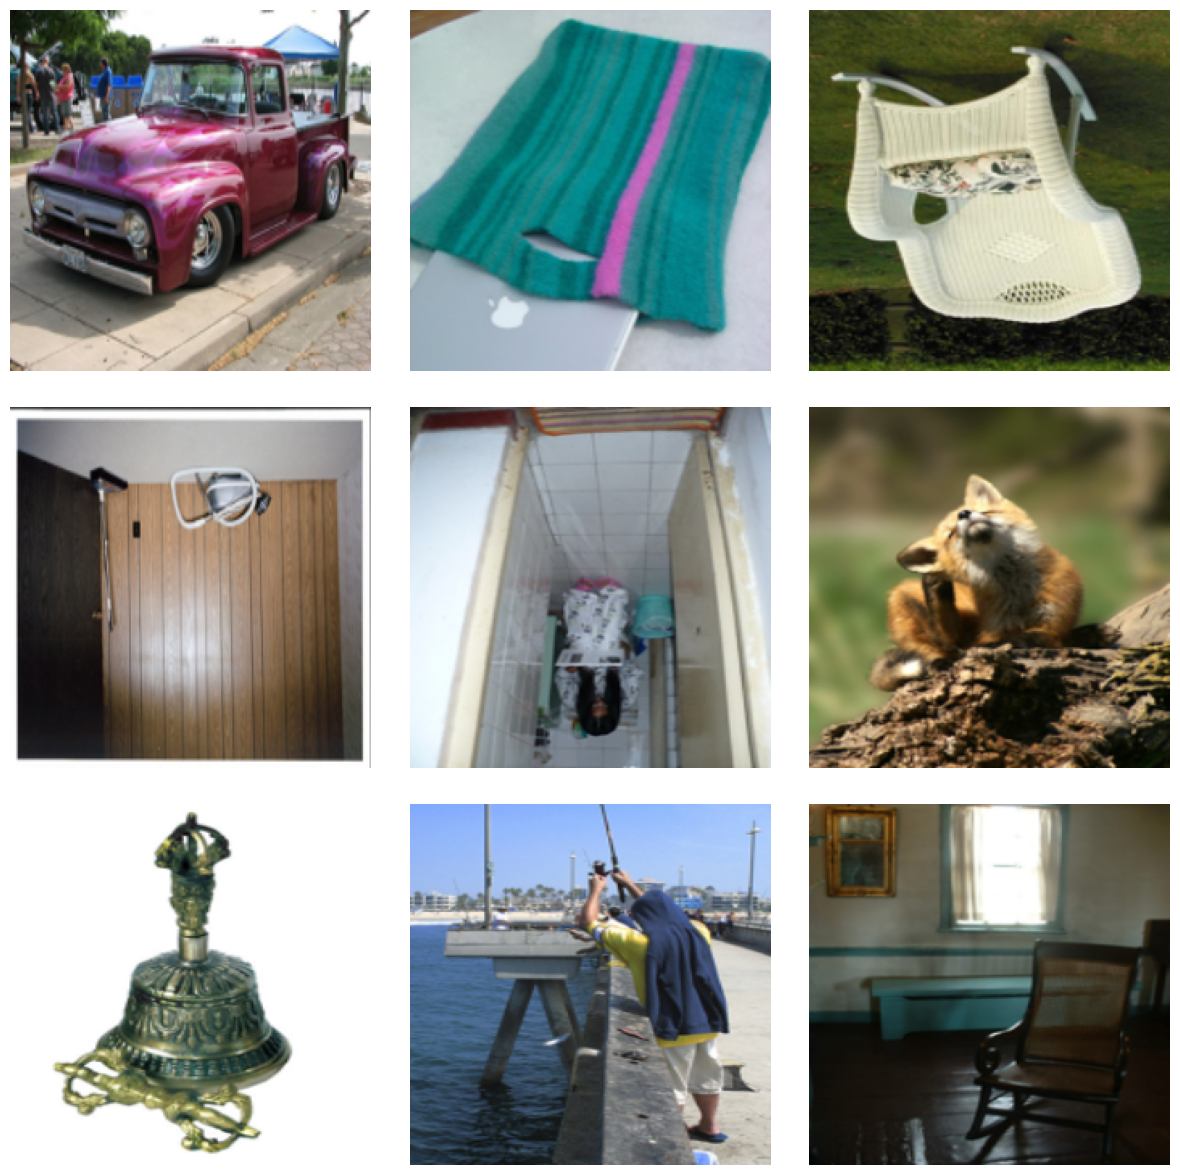

In [15]:
collected_images = []
for img_batch, label_batch in train_dataloader:
  for img_num in range(img_batch.shape[0]):
    collected_images += [img_batch[img_num]]
    if len(collected_images) >= 9:
      break
  if len(collected_images) >= 9:
    break

imshow(torch.stack(collected_images).permute(0, 2, 3, 1), title=None, image_width=5, axis=False,
           color_space="RGB", cols=3, save_to=None,
           hspace=0.1, wspace=0.1,
           use_original_sytle=False, invert=False)

### Create ResNet model

Just as Backup:
```python
# conv 1
self.conv1 = nn.Conv2d(in_channels=(3, 224, 224), out_channels=(64, 112, 112), kernel_size=(7,7), stride=2, padding=0)

# conv 2
self.conv2_max = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=0)
self.conv2_1 = nn.Conv2d(in_channels=(64, 56, 56), out_channels=(64, 56, 56), kernel_size=(3,3), stride=1, padding=1)
self.conv2_2 = nn.Conv2d(in_channels=(64, 56, 56), out_channels=(128, 28, 28), kernel_size=(3,3), stride=2, padding=0)

```

> Next time, just use pretrained/pre build, you may have to adjust the last layer. Building it from ground up is pretty hard...but maybe a good learning.

In [ ]:
# model = torch.nn.models.resnet18(pretrained=False)
# model

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1):
    super(ResidualBlock, self).__init__()

    self.relu = nn.ReLu(inplace=True)

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding)
    self.bn2 = nn.BatchNorm2d(out_channels)

    # skip connection
    self.skip_connection = nn.Sequential(
                              nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                              nn.BatchNorm2d(out_channels)
                          ) if in_channels != out_channels else nn.Identity()

  def forward(self, x):
    identity = self.skip_connection(x)  # save original input

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += identity  # add original input
    out = self.relu(out)

    return out



class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()

    # conv 1
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=2, padding=0)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv1_max = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=0)

    # conv 2
    self.conv2_1 = ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2_2 = ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)

    # conv 3
    self.conv3_1 = ResidualBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv3_2 = ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)

    # conv 4
    self.conv4_1 = ResidualBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv4_2 = ResidualBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)

    # conv 5
    self.conv5_1 = ResidualBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv5_2 = ResidualBlock(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding=1)

    # avf pooling + softmax
    self.avg_pooling = nn.AvgPool2d(kernel_size=(3,3), stride=2, padding=0)
    self.fc = nn.Linear(1024, 100)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # input_x = x.clone()
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.conv1_max(x)

    x = self.conv2_1(x)
    x = self.conv2_2(x)

    x = self.conv3_1(x)
    x = self.conv3_2(x)

    x = self.conv4_1(x)
    x = self.conv4_2(x)

    x = self.conv5_1(x)
    x = self.conv5_2(x)

    x = self.avg_pooling(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    x = self.softmax(x)

    return x

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18().to(device)

# Loss-Funktion
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300

# Training
for epoch in range(num_epochs):
    model.train()

    train_loss = 0
    correct_train = 0
    total_train = 0

    for img_batch, label_batch in train_dataloader:
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        outputs = model(img_batch)
        loss = loss_fn(outputs, label_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == label_batch).sum().item()
        total_train += label_batch.size(0)

    train_accuracy = 100 * correct_train / total_train

    # === Validation Step ===
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation
        for img_batch, label_batch in val_dataloader:
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)

            outputs = model(img_batch)
            loss = loss_fn(outputs, label_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == label_batch).sum().item()
            total_val += label_batch.size(0)

    val_accuracy = 100 * correct_val / total_val

    # Print training and validation results
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss/len(train_dataloader):.4f}, Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss/len(val_dataloader):.4f}, Acc: {val_accuracy:.2f}%")

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

### Evaluation

In [ ]:
print("\nTesting the model on unseen data...")
# model.load_state_dict(torch.load("best_model.pth"))  # Load the best model
model.eval()

test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for img_batch, label_batch in test_dataloader:
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        outputs = model(img_batch)
        loss = loss_fn(outputs, label_batch)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == label_batch).sum().item()
        total_test += label_batch.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss/len(test_dataloader):.4f}, Accuracy: {test_accuracy:.2f}%")